=== Confounder Analysis: Omitted Variable Bias ===

Scenario: Effect of study hours on test scores
- X: Hours studied per week
- Y: Test score (0-100)
- C: Intelligence level (confounder)

True Model Structure:
C (Intelligence) ~ N(0, 1)
X (Study hours) = 5 + 3 * C + noise
Y (Test score) = 50 + 2 * X + 15 * C + noise

Data Summary:
       Intelligence  Study_Hours  Test_Score
count      1000.000     1000.000    1000.000
mean          0.019        5.129      60.559
std           0.979        3.064      20.715
min          -3.241       -4.185      -4.518
25%          -0.648        3.089      46.126
50%           0.025        5.054      60.592
75%           0.648        7.087      74.186
max           3.853       18.308     144.405

=== ANALYSIS RESULTS ===

1. TRUE CORRELATION between Study Hours (X) and Test Scores (Y):
   Correlation = 0.9680

2. CORRECT MODEL (includes Intelligence confounder):
   Y = 50.11 + 1.98*Study_Hours + 15.10*Intelligence
   Estimated effect of Study Hours: 1.

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


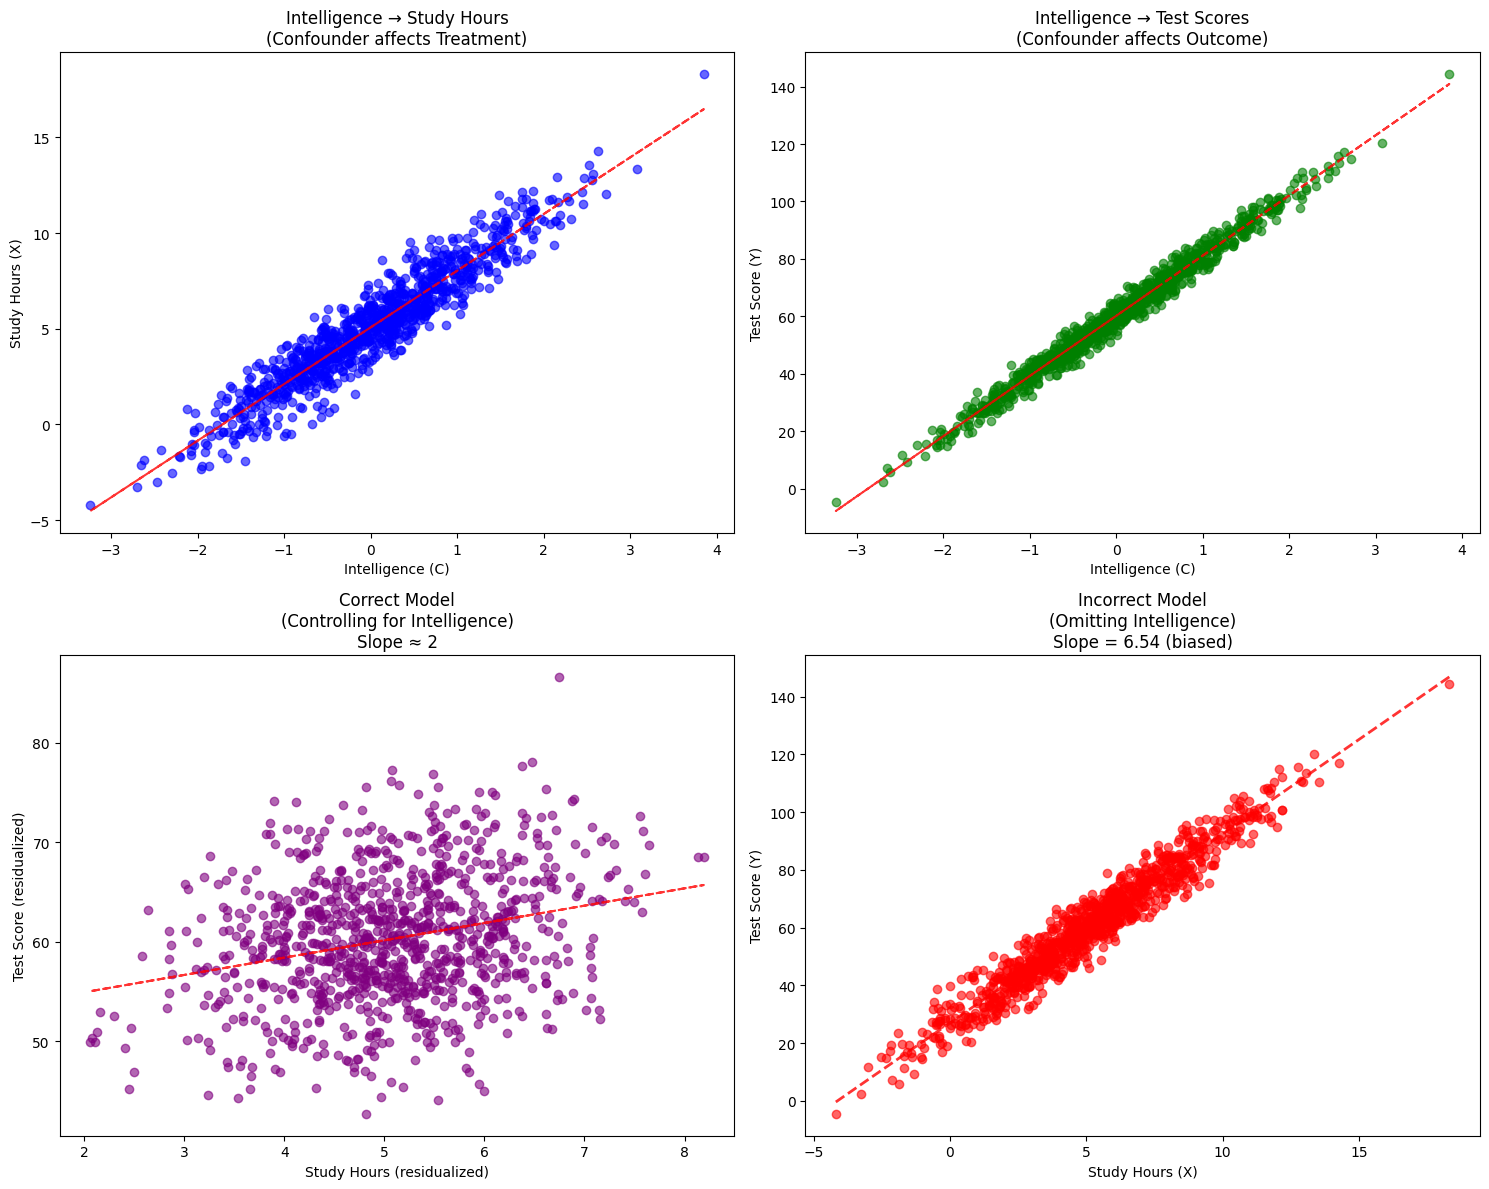


=== SUMMARY STATISTICS ===
True effect of Study Hours: 2
Estimated effect (correct model): 1.9796
Estimated effect (incorrect model): 6.5444
Bias: 4.5444
Bias direction: OVERESTIMATED


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
n = 1000

print("=== Confounder Analysis: Omitted Variable Bias ===\n")

# Create a scenario: Effect of study hours (X) on test scores (Y)
# with intelligence (C) as a confounder

print("Scenario: Effect of study hours on test scores")
print("- X: Hours studied per week")
print("- Y: Test score (0-100)")
print("- C: Intelligence level (confounder)")
print()

# True model coefficients
beta_0 = 50    # Baseline test score
beta_x = 2     # Effect of study hours on test score
beta_c = 15    # Effect of intelligence on test score
gamma_0 = 5    # Baseline study hours
gamma_c = 3    # Effect of intelligence on study hours

print("True Model Structure:")
print(f"C (Intelligence) ~ N(0, 1)")
print(f"X (Study hours) = {gamma_0} + {gamma_c} * C + noise")
print(f"Y (Test score) = {beta_0} + {beta_x} * X + {beta_c} * C + noise")
print()

# Generate the confounder (intelligence)
C = np.random.normal(0, 1, n)

# Generate X (study hours) - influenced by intelligence
X = gamma_0 + gamma_c * C + np.random.normal(0, 1, n)

# Generate Y (test score) - influenced by both study hours AND intelligence
Y = beta_0 + beta_x * X + beta_c * C + np.random.normal(0, 2, n)

# Create DataFrame
df = pd.DataFrame({
    'Intelligence': C,
    'Study_Hours': X,
    'Test_Score': Y
})

print("Data Summary:")
print(df.describe().round(3))
print()

# Calculate TRUE correlation between X and Y
true_correlation = np.corrcoef(X, Y)[0, 1]

# Fit the CORRECT model (includes confounder)
correct_model = LinearRegression()
correct_model.fit(df[['Study_Hours', 'Intelligence']], df['Test_Score'])

# Fit the INCORRECT model (omits confounder)
incorrect_model = LinearRegression()
incorrect_model.fit(df[['Study_Hours']], df['Test_Score'])

print("=== ANALYSIS RESULTS ===")
print()

print("1. TRUE CORRELATION between Study Hours (X) and Test Scores (Y):")
print(f"   Correlation = {true_correlation:.4f}")
print()

print("2. CORRECT MODEL (includes Intelligence confounder):")
print(f"   Y = {correct_model.intercept_:.2f} + {correct_model.coef_[0]:.2f}*Study_Hours + {correct_model.coef_[1]:.2f}*Intelligence")
print(f"   Estimated effect of Study Hours: {correct_model.coef_[0]:.4f}")
print(f"   (True effect is {beta_x})")
print()

print("3. INCORRECT MODEL (omits Intelligence confounder):")
print(f"   Y = {incorrect_model.intercept_:.2f} + {incorrect_model.coef_[0]:.2f}*Study_Hours")
print(f"   Estimated effect of Study Hours: {incorrect_model.coef_[0]:.4f}")
print(f"   (True effect is {beta_x})")
print()

# Calculate bias
bias = incorrect_model.coef_[0] - beta_x
print(f"4. BIAS in coefficient estimate:")
print(f"   Bias = {bias:.4f}")
print(f"   Bias as percentage: {(bias/beta_x)*100:.1f}%")
print()

# Theoretical bias calculation
# Bias = beta_c * gamma_c / Var(X)
theoretical_bias = beta_c * gamma_c / np.var(X)
print(f"5. THEORETICAL BIAS:")
print(f"   Expected bias = β_c * γ_c / Var(X) = {beta_c} * {gamma_c} / {np.var(X):.2f} = {theoretical_bias:.4f}")
print(f"   Observed bias = {bias:.4f}")
print()

# Determine if correlation is over/under estimated
if bias > 0.1:
    bias_direction = "OVERESTIMATED"
elif bias < -0.1:
    bias_direction = "UNDERESTIMATED"
else:
    bias_direction = "approximately correct"

print(f"6. CONCLUSION:")
print(f"   The effect of Study Hours on Test Scores is {bias_direction}")
print(f"   when the Intelligence confounder is omitted from the model.")
print()

print("=== EXPLANATION ===")
print()
print("Why this bias occurs:")
print(f"1. Intelligence (C) positively affects both Study Hours (γ_c = {gamma_c}) and Test Scores (β_c = {beta_c})")
print("2. Students with higher intelligence tend to:")
print("   - Study more hours (positive relationship)")
print("   - Score higher on tests (positive relationship)")
print("3. When we omit Intelligence from the model, the algorithm incorrectly")
print("   attributes the effect of Intelligence on Test Scores to Study Hours")
print("4. This creates an upward bias in the Study Hours coefficient")
print()
print("Mathematical intuition:")
print("- Omitted Variable Bias = (Effect of C on Y) × (Effect of C on X) / Var(X)")
print(f"- In our case: {beta_c} × {gamma_c} / Var(X) = positive bias")
print("- Since both effects are positive, we get positive bias (overestimation)")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Relationship between Intelligence and Study Hours
axes[0,0].scatter(C, X, alpha=0.6, color='blue')
axes[0,0].set_xlabel('Intelligence (C)')
axes[0,0].set_ylabel('Study Hours (X)')
axes[0,0].set_title('Intelligence → Study Hours\n(Confounder affects Treatment)')
z = np.polyfit(C, X, 1)
p = np.poly1d(z)
axes[0,0].plot(C, p(C), "r--", alpha=0.8)

# Plot 2: Relationship between Intelligence and Test Scores
axes[0,1].scatter(C, Y, alpha=0.6, color='green')
axes[0,1].set_xlabel('Intelligence (C)')
axes[0,1].set_ylabel('Test Score (Y)')
axes[0,1].set_title('Intelligence → Test Scores\n(Confounder affects Outcome)')
z = np.polyfit(C, Y, 1)
p = np.poly1d(z)
axes[0,1].plot(C, p(C), "r--", alpha=0.8)

# Plot 3: Correct model (controlling for Intelligence)
# Create residuals after removing Intelligence effect
X_resid = X - gamma_c * C
Y_resid = Y - beta_c * C
axes[1,0].scatter(X_resid, Y_resid, alpha=0.6, color='purple')
axes[1,0].set_xlabel('Study Hours (residualized)')
axes[1,0].set_ylabel('Test Score (residualized)')
axes[1,0].set_title(f'Correct Model\n(Controlling for Intelligence)\nSlope ≈ {beta_x}')
z = np.polyfit(X_resid, Y_resid, 1)
p = np.poly1d(z)
axes[1,0].plot(X_resid, p(X_resid), "r--", alpha=0.8)

# Plot 4: Incorrect model (not controlling for Intelligence)
axes[1,1].scatter(X, Y, alpha=0.6, color='red')
axes[1,1].set_xlabel('Study Hours (X)')
axes[1,1].set_ylabel('Test Score (Y)')
axes[1,1].set_title(f'Incorrect Model\n(Omitting Intelligence)\nSlope = {incorrect_model.coef_[0]:.2f} (biased)')
x_range = np.linspace(X.min(), X.max(), 100)
y_pred = incorrect_model.predict(x_range.reshape(-1, 1))
axes[1,1].plot(x_range, y_pred, "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"True effect of Study Hours: {beta_x}")
print(f"Estimated effect (correct model): {correct_model.coef_[0]:.4f}")
print(f"Estimated effect (incorrect model): {incorrect_model.coef_[0]:.4f}")
print(f"Bias: {bias:.4f}")
print(f"Bias direction: {bias_direction}")

=== Multiple Testing Problem Analysis ===

Model Structure:
W = noise (normally distributed)
X = noise (normally distributed)
Y = 2*X + noise
TRUE coefficient of W = 0 (W has no effect on Y)

Running 1000 independent regression analyses...

=== RESULTS ===
Total simulations: 1000
TRUE coefficient of W: 0

SMALLEST (best) p-value found: 0.000475
Coefficient estimate for smallest p-value: 0.3036

Number of p-values < 0.05: 51
False positive rate: 0.051 (5.1%)
Expected false positive rate: 0.050 (5.0%)

Probability of getting at least one p < 0.05 in 1000 trials:
P(at least one false positive) = 1 - (0.95)^1000 ≈ 1.0000000000
This is essentially 100% - almost guaranteed!

=== SUMMARY STATISTICS ===
Mean p-value: 0.4956
Median p-value: 0.5044
Standard deviation of p-values: 0.2861
Mean coefficient estimate: 0.0030
Standard deviation of coefficients: 0.1028

=== INTERPRETATION ===

1. DOES A P-VALUE < 0.05 MEAN THE COEFFICIENT IS ACTUALLY NONZERO?
   NO! We know the true coefficient is exac

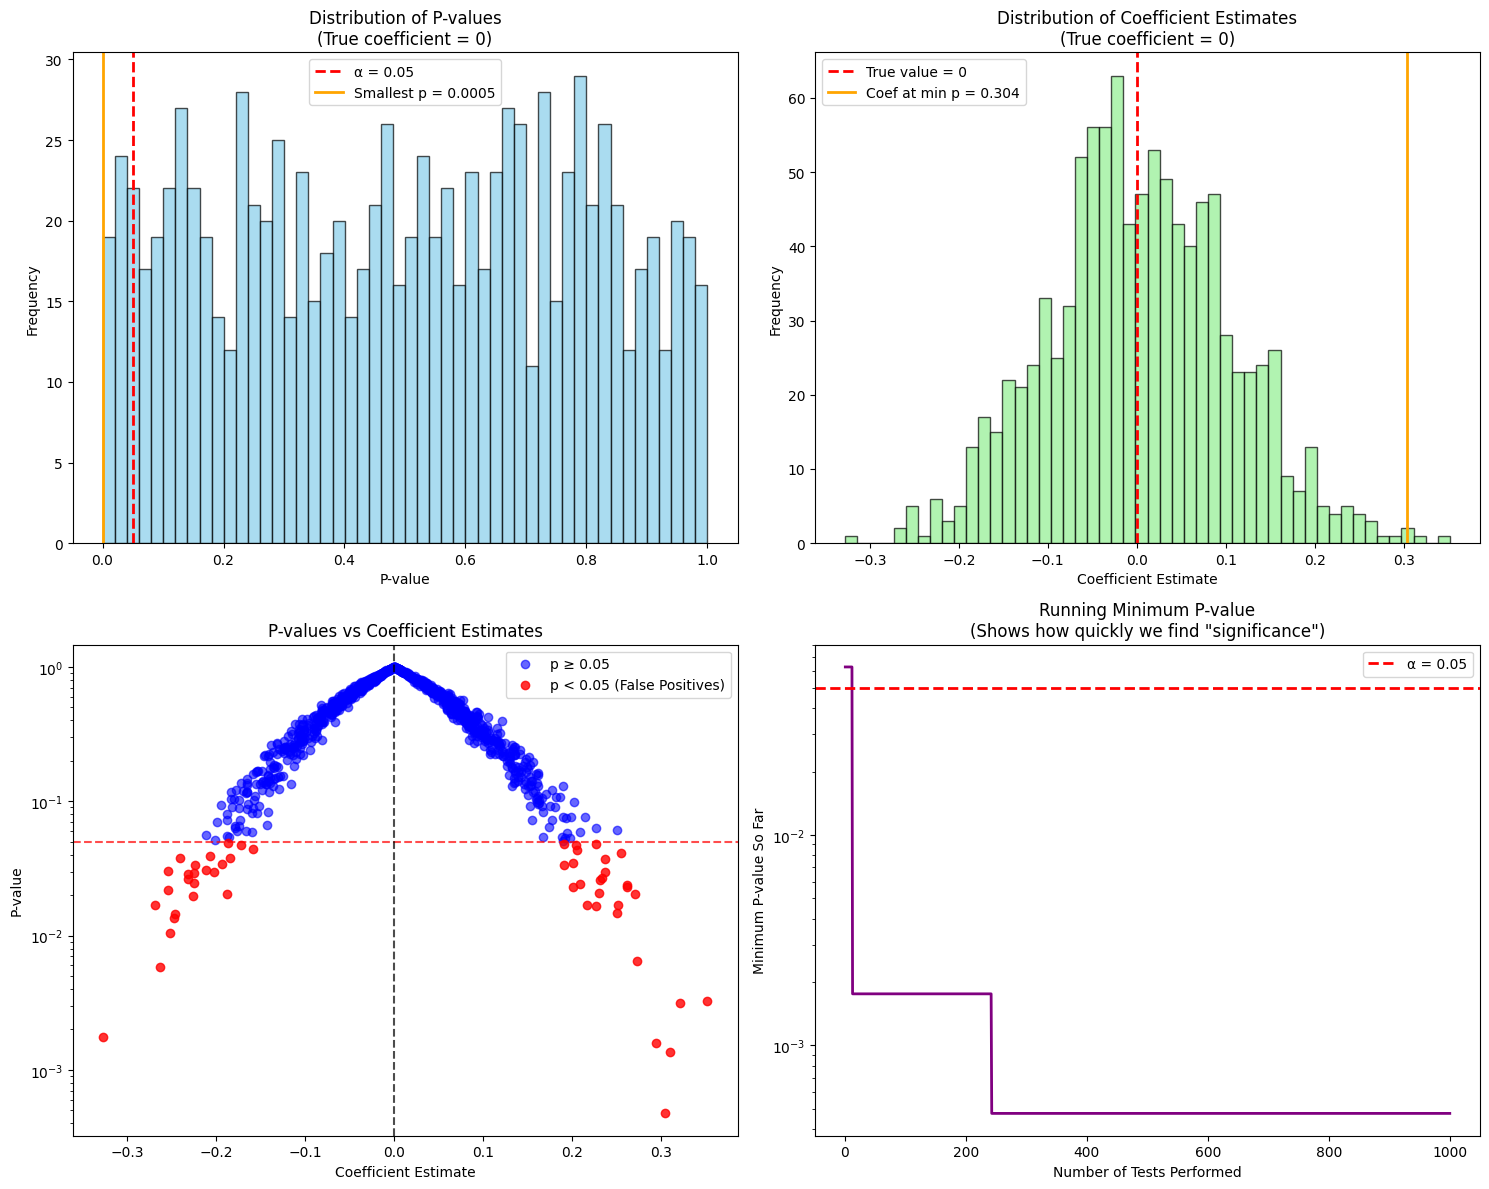


=== FINAL ANSWER ===
Best (smallest) p-value after 1000 tests: 0.000475
This p-value is < 0.05

Even though this p-value is < 0.05, the coefficient is NOT actually nonzero!
This is a FALSE POSITIVE caused by multiple testing.


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

print("=== Multiple Testing Problem Analysis ===\n")

def run_single_regression():
    """
    Run a single regression where W has zero effect on Y
    Returns the p-value for the coefficient of W
    """
    n = 100  # Sample size
    
    # Generate data where W has NO effect on Y
    W = np.random.normal(0, 1, n)  # W is just noise
    X = np.random.normal(0, 1, n)  # X is just noise
    Y = 2 * X + np.random.normal(0, 1, n)  # Y depends only on X, not W
    
    # Create design matrix
    design_matrix = np.column_stack([W, X])
    
    # Fit regression: Y = β₀ + β₁W + β₂X + ε
    model = LinearRegression()
    model.fit(design_matrix, Y)
    
    # Calculate residuals and standard errors manually for p-values
    y_pred = model.predict(design_matrix)
    residuals = Y - y_pred
    n_params = design_matrix.shape[1] + 1  # +1 for intercept
    df_resid = n - n_params
    mse = np.sum(residuals**2) / df_resid
    
    # Add intercept column for full design matrix
    full_design = np.column_stack([np.ones(n), design_matrix])
    
    # Calculate covariance matrix and standard errors
    try:
        cov_matrix = mse * np.linalg.inv(full_design.T @ full_design)
        std_errors = np.sqrt(np.diag(cov_matrix))
        
        # T-statistics and p-values
        # Index 1 corresponds to W coefficient (after intercept at index 0)
        w_coefficient = model.coef_[0]  # Coefficient of W
        w_std_error = std_errors[1]    # Standard error of W coefficient
        t_stat = w_coefficient / w_std_error
        p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df_resid))  # Two-tailed test
        
        return p_value, w_coefficient, w_std_error, t_stat
    except:
        # In case of numerical issues
        return 1.0, 0.0, 1.0, 0.0

print("Model Structure:")
print("W = noise (normally distributed)")
print("X = noise (normally distributed)")
print("Y = 2*X + noise")
print("TRUE coefficient of W = 0 (W has no effect on Y)")
print()

# Run the analysis 1000 times
n_simulations = 1000
p_values = []
coefficients = []
all_results = []

print(f"Running {n_simulations} independent regression analyses...")

for i in range(n_simulations):
    p_val, coef, std_err, t_stat = run_single_regression()
    p_values.append(p_val)
    coefficients.append(coef)
    all_results.append({
        'simulation': i+1,
        'p_value': p_val,
        'coefficient': coef,
        'std_error': std_err,
        't_statistic': t_stat
    })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_results)

# Analysis of results
p_values = np.array(p_values)
coefficients = np.array(coefficients)

print(f"\n=== RESULTS ===")
print(f"Total simulations: {n_simulations}")
print(f"TRUE coefficient of W: 0")
print()

# Find the smallest p-value
min_p_value = np.min(p_values)
min_p_index = np.argmin(p_values)
min_p_coefficient = coefficients[min_p_index]

print(f"SMALLEST (best) p-value found: {min_p_value:.6f}")
print(f"Coefficient estimate for smallest p-value: {min_p_coefficient:.4f}")
print()

# Count how many p-values are < 0.05 (false positives)
significant_count = np.sum(p_values < 0.05)
false_positive_rate = significant_count / n_simulations

print(f"Number of p-values < 0.05: {significant_count}")
print(f"False positive rate: {false_positive_rate:.3f} ({false_positive_rate*100:.1f}%)")
print(f"Expected false positive rate: 0.050 (5.0%)")
print()

# Probability of getting at least one p < 0.05 in 1000 trials
prob_at_least_one = 1 - (0.95)**n_simulations
print(f"Probability of getting at least one p < 0.05 in {n_simulations} trials:")
print(f"P(at least one false positive) = 1 - (0.95)^{n_simulations} ≈ {prob_at_least_one:.10f}")
print("This is essentially 100% - almost guaranteed!")
print()

# Summary statistics
print(f"=== SUMMARY STATISTICS ===")
print(f"Mean p-value: {np.mean(p_values):.4f}")
print(f"Median p-value: {np.median(p_values):.4f}")
print(f"Standard deviation of p-values: {np.std(p_values):.4f}")
print(f"Mean coefficient estimate: {np.mean(coefficients):.4f}")
print(f"Standard deviation of coefficients: {np.std(coefficients):.4f}")
print()

print("=== INTERPRETATION ===")
print()
print("1. DOES A P-VALUE < 0.05 MEAN THE COEFFICIENT IS ACTUALLY NONZERO?")
print("   NO! We know the true coefficient is exactly zero, yet we found")
print(f"   {significant_count} cases where p < 0.05 (false positives).")
print()
print("2. WHAT IS THE PROBLEM WITH REPEATING THE ANALYSIS?")
print("   - Each test has a 5% chance of false positive (Type I error)")
print("   - With 1000 independent tests, we expect ~50 false positives")
print("   - The probability of getting at least one false positive approaches 100%")
print("   - This is called the 'Multiple Comparisons Problem'")
print()
print("3. WHY IS THIS PROBLEMATIC?")
print("   - Researchers might 'cherry-pick' the most significant result")
print("   - This inflates the false discovery rate far above 5%")
print("   - It's essentially 'p-hacking' or 'data dredging'")
print("   - The smallest p-value doesn't represent the true relationship")
print()
print("4. SOLUTIONS:")
print("   - Bonferroni correction: Use α/n instead of α (e.g., 0.05/1000 = 0.00005)")
print("   - False Discovery Rate (FDR) control methods")
print("   - Pre-registration of hypotheses")
print("   - Replication studies")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Distribution of p-values
axes[0,0].hist(p_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
axes[0,0].axvline(x=min_p_value, color='orange', linestyle='-', linewidth=2, 
                  label=f'Smallest p = {min_p_value:.4f}')
axes[0,0].set_xlabel('P-value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of P-values\n(True coefficient = 0)')
axes[0,0].legend()

# Plot 2: Distribution of coefficient estimates
axes[0,1].hist(coefficients, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='True value = 0')
axes[0,1].axvline(x=min_p_coefficient, color='orange', linestyle='-', linewidth=2,
                  label=f'Coef at min p = {min_p_coefficient:.3f}')
axes[0,1].set_xlabel('Coefficient Estimate')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Coefficient Estimates\n(True coefficient = 0)')
axes[0,1].legend()

# Plot 3: P-values vs Coefficient estimates
significant_mask = p_values < 0.05
axes[1,0].scatter(coefficients[~significant_mask], p_values[~significant_mask], 
                  alpha=0.6, color='blue', label='p ≥ 0.05')
axes[1,0].scatter(coefficients[significant_mask], p_values[significant_mask], 
                  alpha=0.8, color='red', label='p < 0.05 (False Positives)')
axes[1,0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
axes[1,0].axvline(x=0, color='black', linestyle='--', alpha=0.7)
axes[1,0].set_xlabel('Coefficient Estimate')
axes[1,0].set_ylabel('P-value')
axes[1,0].set_title('P-values vs Coefficient Estimates')
axes[1,0].legend()
axes[1,0].set_yscale('log')

# Plot 4: Running minimum p-value
running_min = np.minimum.accumulate(p_values)
axes[1,1].plot(range(1, n_simulations+1), running_min, color='purple', linewidth=2)
axes[1,1].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
axes[1,1].set_xlabel('Number of Tests Performed')
axes[1,1].set_ylabel('Minimum P-value So Far')
axes[1,1].set_title('Running Minimum P-value\n(Shows how quickly we find "significance")')
axes[1,1].legend()
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n=== FINAL ANSWER ===")
print(f"Best (smallest) p-value after {n_simulations} tests: {min_p_value:.6f}")
print(f"This p-value is {'< 0.05' if min_p_value < 0.05 else '≥ 0.05'}")
print()
if min_p_value < 0.05:
    print("Even though this p-value is < 0.05, the coefficient is NOT actually nonzero!")
    print("This is a FALSE POSITIVE caused by multiple testing.")
else:
    print("In this particular run, even the smallest p-value was ≥ 0.05.")
    print("But in most runs, we would find at least one false positive.")